In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
import string
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')

In [35]:
df_input = pd.read_csv("../data/raw/train.csv")
print(df_input.shape)
df_input.head()

(16784, 30)


,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,mileage,omv,arf,opc_scheme,lifespan,eco_category,features,accessories,indicative_price,price
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,73000.0,45330.0,50462.0,NaN,NaN,uncategorized,"5 doors gt, powerful and fuel efficient 2.0l t...","bmw i-drive, navigation, bluetooth/aux/usb inp...",NaN,71300.0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,110112.0,27502.0,1376.0,NaN,25-jan-2035,uncategorized,low mileage unit. well maintained vehicle. vie...,factory radio setting. front recording camera....,NaN,43800.0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,80000.0,27886.0,26041.0,NaN,NaN,uncategorized,responsive and fuel efficient 1.6l inline 4 cy...,dual electric/memory seats. factory fitted aud...,NaN,95500.0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,9800.0,46412.0,56977.0,NaN,NaN,uncategorized,"1.5l inline-4 twin scroll turbocharged engine,...",64 colour ambient lighting. active parking ass...,NaN,197900.0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,40000.0,20072.0,20101.0,NaN,NaN,uncategorized,"1.6l i-vtec engine, 123 bhp, earth dreams cvt ...","s/rims, premium leather seats, factory touch s...",NaN,103200.0


# Variable Types

In [8]:
target = "price"

In [9]:
cat_vars = [var for var in df_input.columns if df_input[var].dtype == 'O']
cat_vars = cat_vars + ['listing_id']
print (f"length of categorical variables: {len(cat_vars)}")
print (f"categorical variable names: {cat_vars}")
# "original_reg_date", "reg_date", "lifespan" are misclassified, they should belong to date


length of categorical variables: 17
categorical variable names: ['listing_id', 'title', 'make', 'model', 'description', 'original_reg_date', 'reg_date', 'type_of_vehicle', 'category', 'transmission', 'fuel_type', 'opc_scheme', 'lifespan', 'eco_category', 'features', 'accessories', 'listing_id']


In [10]:
time_vars = ["original_reg_date", "reg_date", "lifespan", 'manufactured']
for i in time_vars:
    if i in cat_vars:
        cat_vars.remove(i)

In [11]:
df_input[cat_vars] = df_input[cat_vars].astype('O')

In [12]:
num_vars = [
    var for var in df_input.columns if var not in cat_vars+time_vars and var != target
]

print (f"length of numerical variables: {len(num_vars)}")
print (f"numerical variable names: {num_vars}")

length of numerical variables: 12
numerical variable names: ['curb_weight', 'power', 'engine_cap', 'no_of_owners', 'depreciation', 'coe', 'road_tax', 'dereg_value', 'mileage', 'omv', 'arf', 'indicative_price']


# Text features

[description, accessories, features, title, category]
1. length of the descriptions
2. tokenize the words
https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author
3. add target encoding for `category` column

In [14]:
df_input[["description", "accessories", "features", "title", "category"]].head(5)

,description,accessories,features,title,category
0,1 owner! 320i gt m-sports model! big brake kit...,"bmw i-drive, navigation, bluetooth/aux/usb inp...","5 doors gt, powerful and fuel efficient 2.0l t...",BMW 3 Series 320i Gran Turismo M-Sport,"parf car, premium ad car, low mileage car"
1,high loan available! low mileage unit. wear an...,factory radio setting. front recording camera....,low mileage unit. well maintained vehicle. vie...,Toyota Hiace 3.0M,premium ad car
2,1 owner c&c unit. full agent service with 1 mo...,dual electric/memory seats. factory fitted aud...,responsive and fuel efficient 1.6l inline 4 cy...,Mercedes-Benz CLA-Class CLA180,"parf car, premium ad car"
3,"fully agent maintained, 3 years warranty 10 ye...",64 colour ambient lighting. active parking ass...,"1.5l inline-4 twin scroll turbocharged engine,...",Mercedes-Benz E-Class E180 Avantgarde,"parf car, almost new car, consignment car"
4,"kah motor unit! 1 owner, lowest 1.98% for full...","s/rims, premium leather seats, factory touch s...","1.6l i-vtec engine, 123 bhp, earth dreams cvt ...",Honda Civic 1.6A VTi,parf car


- ### category

In [60]:
def _remove_punctuation(word):
    punch = string.punctuation
    for p in punch:
        word = word.replace(p, '')
    word = word.replace('…', '')
    word = word.replace('–', '')
    word = word.replace("’", '')
    return word

In [36]:
def generate_categories(df):
    df["category_clean"] = df["category"].apply(lambda x: 
                                                [_remove_punctuation(i.strip()) for i in x.split(",")]
                                               )

    all_category = []
    for i in df["category_clean"]:
        all_category += i
    all_category_clean = [i for i in list(set(all_category)) if i != '']
    
    return all_category_clean

def add_category_features(df):
    df["category_clean"] = df["category"].apply(lambda x: 
                                                [_remove_punctuation(i.strip()) for i in x.split(",")]
                                               )
    for i in all_category_clean:
        col_name = f"is_{i.replace(' ', '_')}"
        df[col_name] = df["category_clean"].apply(lambda x: np.where(col_name in x, 1, 0))
    
    return df

In [42]:
all_category_clean = generate_categories(df_input)
add_category_features(df_input).head(5)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,is_low_mileage_car,is_imported_used_vehicle,is_premium_ad_car,is_rare__exotic,is_electric_cars,is_opc_car,is_vintage_cars,is_sgcarmart_warranty_cars,is_consignment_car,is_direct_owner_sale
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,0,0,0,0,0,0,0,0,0,0
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,0,0,0,0,0,0,0,0,0,0
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,0,0,0,0,0,0,0,0,0,0
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,0,0,0,0,0,0,0,0,0,0
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,0,0,0,0,0,0,0,0,0,0


- ### title

In [44]:
# title is not a unique column for each listing
print(df_input.shape)
print(len(df_input["title"].unique()))

(16784, 31)
5775


In [45]:
# based on dataset description 
# title - title of the listing; free text attribute typically containing the make, model, engine type/size
df_input[['title', 'make', 'model', 'engine_cap']]

,title,make,model,engine_cap
0,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1997.0
1,Toyota Hiace 3.0M,NaN,hiace,2982.0
2,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1595.0
3,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,1497.0
4,Honda Civic 1.6A VTi,NaN,civic,1597.0
...,...,...,...,...
16779,Volvo XC90 T5 Momentum,volvo,xc90,1969.0
16780,Hyundai Ioniq Hybrid 1.6A DCT Sunroof,hyundai,ioniq,1580.0
16781,MINI Cooper Cabriolet 1.6A (COE till 08/2030),mini,cooper,1598.0
16782,Honda Fit 1.3A G F-Package,NaN,fit,1317.0


/Users/user/.pyenv/versions/anaconda3-5.2.0/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


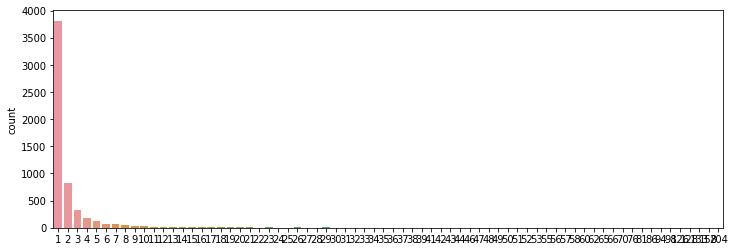

In [53]:
count = df_input["title"].value_counts()
plt.figure(figsize=(12,4))  
sns.countplot(list(count))
plt.show()

Most of the title are unique, or very rare appearance as shown by the high number in low counts. And the title information which includes make, model and engine cap are included in other columns alrdy, this column does give new information thus can possibly be droped.

- ### features, accessories, description

In [55]:
# features are almost unique
print(df_input.shape)
print(len(df_input["features"].unique()))

(16784, 31)
10688


In [59]:
df["features"][0]

'5 doors gt, powerful and fuel efficient 2.0l twin power turbo engine, keyless start/stop, bluetooth, drive select eco, normal. retractable spoiler. view specs of the bmw 3 series gran turismo'

In [81]:
def _remove_stopwords(tokens):
    stopwords_list = stopwords.words('english')
    tokens = [i for i in tokens if i not in stopwords_list]
    return tokens

def _remove_numbers(tokens):
    tokens = [i for i in tokens if not i.isdigit()]
    return tokens

def _to_lower_case(tokens):
    tokens = [word.lower() for word in tokens]
    return tokens

In [95]:
def add_basic_text_features(df):
    text_cols = ["features", "accessories", "description"]
    eng_stopwords = stopwords.words('english')
    
    for col in text_cols:
        df[f"{col}_num_words"] = df[col].apply(lambda x: len(str(x).split()))
        df[f"{col}_num_unique_words"] = df[col].apply(lambda x: len(set(str(x).split())))
        df[f"{col}_num_chars"] = df[col].apply(lambda x: len(str(x)))
        df[f"{col}_num_chars"] = df[col].apply(lambda x: len(str(x)))
        df[f"{col}_num_stopwords"] = df[col].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
        df[f"{col}_num_punctuations"] =df[col].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )        df[f"{col}_mean_word_len"] = df[col].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    
    return df

In [105]:
add_basic_text_features(df_input).head(5)

,listing_id,title,make,model,description,manufactured,original_reg_date,reg_date,type_of_vehicle,category,...,accessories_num_punctuations,accessories_num_words_upper,accessories_mean_word_len,description_num_words,description_num_unique_words,description_num_chars,description_num_stopwords,description_num_punctuations,description_num_words_upper,description_mean_word_len
0,1030324,BMW 3 Series 320i Gran Turismo M-Sport,bmw,320i,1 owner! 320i gt m-sports model! big brake kit...,2013.0,NaN,09-dec-2013,luxury sedan,"parf car, premium ad car, low mileage car",...,11,0,7.466667,47,44,304,8,13,0,5.489362
1,1021510,Toyota Hiace 3.0M,NaN,hiace,high loan available! low mileage unit. wear an...,2014.0,NaN,26-jan-2015,van,premium ad car,...,4,0,7.363636,57,52,358,16,11,0,5.298246
2,1026909,Mercedes-Benz CLA-Class CLA180,mercedes-benz,cla180,1 owner c&c unit. full agent service with 1 mo...,2016.0,NaN,25-jul-2016,luxury sedan,"parf car, premium ad car",...,10,0,6.526316,39,36,228,11,10,0,4.871795
3,1019371,Mercedes-Benz E-Class E180 Avantgarde,mercedes-benz,e180,"fully agent maintained, 3 years warranty 10 ye...",2019.0,NaN,17-nov-2020,luxury sedan,"parf car, almost new car, consignment car",...,9,0,6.842105,21,20,134,4,6,0,5.428571
4,1031014,Honda Civic 1.6A VTi,NaN,civic,"kah motor unit! 1 owner, lowest 1.98% for full...",2019.0,NaN,20-sep-2019,mid-sized sedan,parf car,...,10,0,6.947368,50,44,308,13,13,0,5.180000


In [90]:
def generate_tfidf(column_name):
    dataset = list(df_input[column_name].dropna())
    tfIdfTransformer = TfidfTransformer(use_idf=True)
    countVectorizer = CountVectorizer()
    wordCount = countVectorizer.fit_transform(dataset)
    newTfIdf = tfIdfTransformer.fit_transform(wordCount)
    df_features_tfidf = pd.DataFrame(newTfIdf[0].T.todense(), index=countVectorizer.get_feature_names(), columns=["TF-IDF"])
    df_features_tfidf = df_features_tfidf.sort_values('TF-IDF', ascending=False)
    return df_features_tfidf

def build_wordcloud(tfidf_df):
    text = ''
    for word, tfidf in tfidf_df.to_dict()['TF-IDF'].items():
        for i in range(math.ceil(tfidf)):
            text = text + word + ' '

    wordcloud_features = WordCloud(stopwords=STOPWORDS, 
                                   background_color="white",
                                   width=10000, height=5000).generate(text)
    img_demo = plt.imshow(wordcloud_features)
    plt.axis("off")
    plt.show()

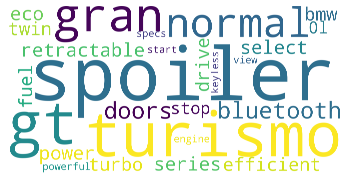

In [91]:
df_features_tfidf = generate_tfidf("features")
build_wordcloud(df_features_tfidf)

In [96]:
print(df_features_tfidf.shape)

(6381, 1)


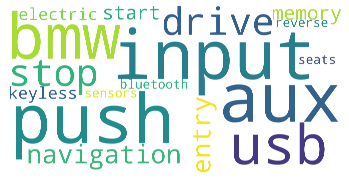

In [92]:
df_accessories_tfidf = generate_tfidf("accessories")
build_wordcloud(df_accessories_tfidf)

In [97]:
print(df_accessories_tfidf.shape)

(5185, 1)


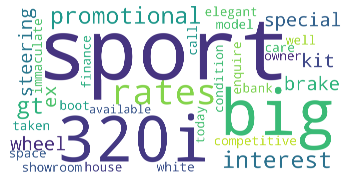

In [93]:
df_description_tfidf = generate_tfidf("description")
build_wordcloud(df_description_tfidf)

In [98]:
print(df_description_tfidf.shape)

(11095, 1)


In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = list(df_input["features"].dropna())
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(X.shape)

(16325, 6381)


In [113]:
len(corpus)

16325

- examine tfidf matrix for each row, find the tfidf that has the highest correlation with the target variable and add that as the feature
- try out word embedding
- [optional] try out sentment analysis score for each column